Fitting a model with 64 free scalar parameters with only 20 data points will result in a degenerate solution.
c:\Users\28489\.conda\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


构建的图包含 5 个节点和 0 条边


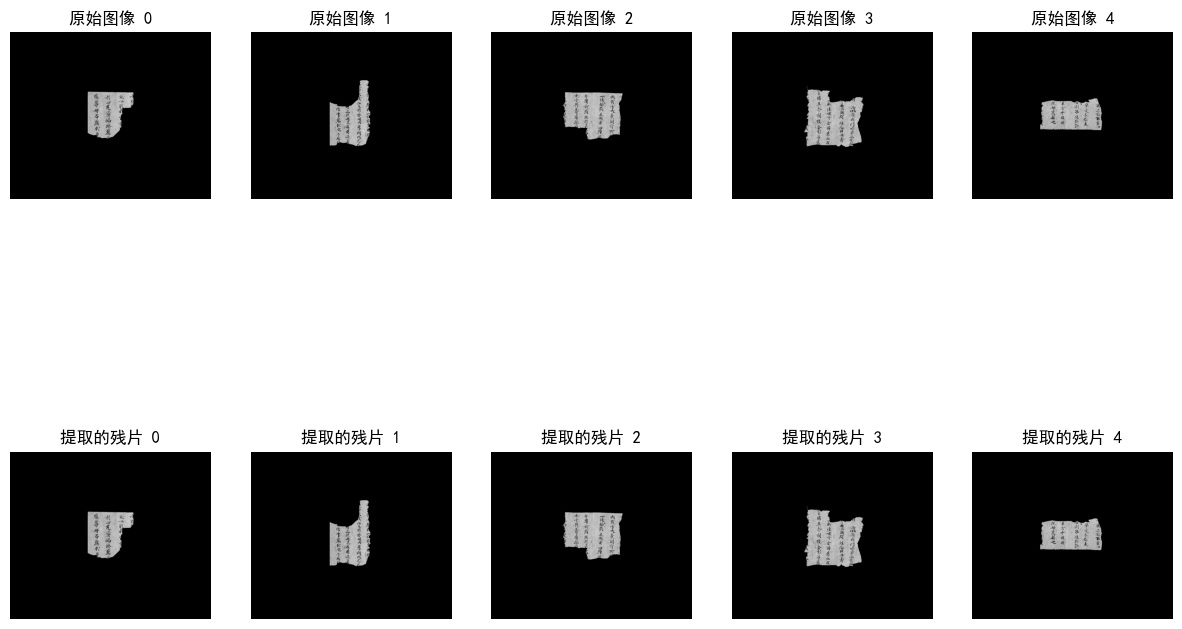

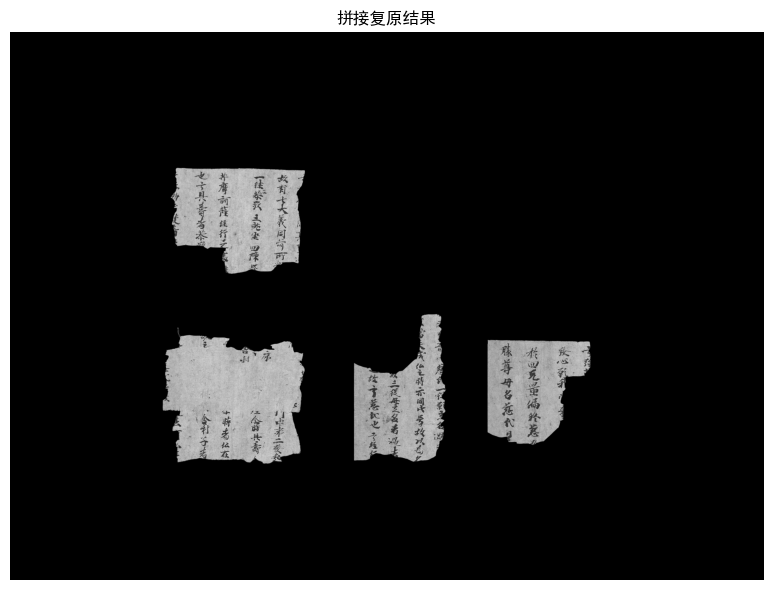

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Optional, Tuple, Union
import torch
from transformers import BertModel, BertTokenizer
from hmmlearn import hmm
from scipy.spatial.distance import cdist

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

class GraphNode:
    def __init__(
        self,
        node_id: int,
        freeman_codes: Dict[str, List[int]],
        centroid: Tuple[float, float],
        contour_centroids: List[Tuple[float, float]],
        semantic_vector: Optional[np.ndarray] = None,
        contours: Optional[List[np.ndarray]] = None,
        image_id: Optional[int] = None,
        original_image: Optional[np.ndarray] = None
    ):
        self.id = node_id
        self.freeman_codes = freeman_codes
        self.centroid = centroid
        self.contour_centroids = contour_centroids
        self.semantic_vector = semantic_vector
        self.contours = contours
        self.image_id = image_id
        self.original_image = original_image
        
    def __repr__(self):
        return f"GraphNode(id={self.id}, image_id={self.image_id}, centroid={self.centroid})"

class GraphEdge:
    def __init__(self, node1: int, node2: int, weight: Optional[float] = None):
        self.node1 = node1
        self.node2 = node2
        self.weight = weight
        
    def __repr__(self):
        return f"GraphEdge({self.node1} <-> {self.node2}, weight={self.weight})"

class Graph:
    def __init__(self):
        self.nodes: Dict[int, GraphNode] = {}
        self.edges: List[GraphEdge] = []
        self._next_node_id = 0
        
    def add_node(self, freeman_codes, centroid, contour_centroids, text=None, bert_model=None, bert_tokenizer=None, contours=None, image_id=None, original_image=None):
        semantic_vector = None
        if text and bert_model and bert_tokenizer:
            semantic_vector = self._generate_bert_vector(text, bert_model, bert_tokenizer)
        
        node_id = self._next_node_id
        self.nodes[node_id] = GraphNode(
            node_id=node_id,
            freeman_codes=freeman_codes,
            centroid=centroid,
            contour_centroids=contour_centroids,
            semantic_vector=semantic_vector,
            contours=contours,
            image_id=image_id,
            original_image=original_image
        )
        self._next_node_id += 1
        return node_id
    
    def add_edge(self, node1: int, node2: int, weight: Optional[float] = None):
        if node1 not in self.nodes or node2 not in self.nodes:
            raise ValueError("One or both nodes do not exist in the graph")
        self.edges.append(GraphEdge(node1, node2, weight))
    
    def _generate_bert_vector(self, text, bert_model, bert_tokenizer):
        inputs = bert_tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        return outputs.last_hidden_state[:, 0, :].numpy()
    
    def visualize(self, stitched_image: Optional[np.ndarray] = None):
        plt.figure(figsize=(15, 10))
        
        # 显示原始图像和提取的残片
        unique_image_ids = set(node.image_id for node in self.nodes.values())
        for idx, img_id in enumerate(unique_image_ids, 1):
            node = next(n for n in self.nodes.values() if n.image_id == img_id)
            original_img = node.original_image
            
            # 提取残片区域
            mask = np.zeros_like(original_img)
            cv2.drawContours(mask, [np.vstack(node.contours)], -1, (255), thickness=cv2.FILLED)
            fragment = cv2.bitwise_and(original_img, original_img, mask=mask)
            
            # 显示原始图像
            plt.subplot(2, len(unique_image_ids), idx)
            plt.imshow(original_img, cmap='gray')
            plt.title(f'原始图像 {img_id}')
            plt.axis('off')
            
            # 显示提取的残片
            plt.subplot(2, len(unique_image_ids), idx + len(unique_image_ids))
            plt.imshow(fragment, cmap='gray')
            plt.title(f'提取的残片 {img_id}')
            plt.axis('off')
        
        # 显示拼接结果
        if stitched_image is not None:
            plt.figure(figsize=(10, 6))
            plt.imshow(stitched_image, cmap='gray')
            plt.title('拼接复原结果')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

class GraphBuilder:
    def __init__(self):
        self.graph = Graph()
        self._contour_processor = ContourProcessor()
    
    def build_from_images(self, image_paths, texts=None, bert_model=None, bert_tokenizer=None):
        if texts and len(texts) != len(image_paths):
            raise ValueError("文本数量必须与图像数量匹配")
        
        node_ids = []
        original_imgs = {}
        for img_idx, image_path in enumerate(image_paths):
            original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if original_img is None:
                raise ValueError(f"无法读取图像: {image_path}")
            original_imgs[img_idx] = original_img
            
            text = texts[img_idx] if texts else None
            segments, chain_codes = self._contour_processor.process_image(image_path)
            
            contour_centroids = [self._compute_centroid(seg) for seg in segments]
            all_contour_points = np.vstack(segments)
            centroid = self._compute_centroid(all_contour_points)
            
            freeman_codes = {'E1': chain_codes[0], 'E2': chain_codes[1], 'E3': chain_codes[2], 'E4': chain_codes[3]}
            
            node_id = self.graph.add_node(
                freeman_codes=freeman_codes,
                centroid=centroid,
                contour_centroids=contour_centroids,
                text=text,
                bert_model=bert_model,
                bert_tokenizer=bert_tokenizer,
                contours=segments,
                image_id=img_idx,
                original_image=original_img
            )
            node_ids.append(node_id)
        
        # 计算轮廓匹配特征
        contour_match_features = self._compute_contour_match_features(node_ids)
        
        # 使用HMM找到最佳序列
        optimal_sequence = self._train_hmm_and_get_sequence(contour_match_features, len(image_paths))
        
        # 重建图结构并拼接图像
        stitched_image = self._stitch_images_based_on_sequence(node_ids, optimal_sequence)
        
        return self.graph, stitched_image
    
    def _compute_centroid(self, contour):
        M = cv2.moments(contour)
        cx = int(M['m10'] / (M['m00'] + 1e-5))
        cy = int(M['m01'] / (M['m00'] + 1e-5))
        return (cx, cy)
    
    def _compute_contour_match_features(self, node_ids):
        """计算所有轮廓之间的匹配度特征"""
        n_nodes = len(node_ids)
        features = np.zeros((n_nodes, 4))  # 每个节点4个边的最大匹配度
        
        for i, node1_id in enumerate(node_ids):
            node1 = self.graph.nodes[node1_id]
            max_scores = np.zeros(4)
            
            for j, node2_id in enumerate(node_ids):
                if i == j:
                    continue
                
                node2 = self.graph.nodes[node2_id]
                edge_scores = np.zeros(4)
                
                for edge_idx in range(4):
                    contour1 = node1.contours[edge_idx]
                    contour2 = node2.contours[(edge_idx + 2) % 4]  # 对面的边更可能匹配
                    
                    # 计算轮廓匹配度
                    match_score = self._contour_processor.evaluate_contour_match(contour1, contour2)
                    edge_scores[edge_idx] = match_score
                
                # 更新最大匹配度
                max_scores = np.maximum(max_scores, edge_scores)
            
            features[i] = max_scores
        
        return features
    
    def _train_hmm_and_get_sequence(self, observations, n_states):
        """训练HMM并获取最优序列"""
        model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
        model.fit(observations)
        log_prob, state_sequence = model.decode(observations, algorithm="viterbi")
        return state_sequence
    
    def _stitch_images_based_on_sequence(self, node_ids, sequence):
        """根据HMM序列拼接图像"""
        # 获取按序列排序的节点
        sorted_indices = np.argsort(sequence)
        sorted_nodes = [self.graph.nodes[node_ids[i]] for i in sorted_indices]
        
        # 初始化第一个碎片的位置
        offsets = [(0, 0)]  # (x, y)偏移量
        
        # 计算每个碎片的相对位置
        for i in range(1, len(sorted_nodes)):
            prev_node = sorted_nodes[i-1]
            curr_node = sorted_nodes[i]
            
            # 找到最佳匹配边
            best_edge = 0
            best_score = 0
            for edge_idx in range(4):
                contour1 = prev_node.contours[edge_idx]
                contour2 = curr_node.contours[(edge_idx + 2) % 4]
                score = self._contour_processor.evaluate_contour_match(contour1, contour2)
                if score > best_score:
                    best_score = score
                    best_edge = edge_idx
            
            # 根据匹配边计算偏移量
            prev_offset = offsets[-1]
            contour_length = int(self._get_contour_length(prev_node.contours[best_edge]))
            
            if best_edge == 0:   # 右
                new_offset = (prev_offset[0], prev_offset[1] + contour_length)
            elif best_edge == 1: # 下
                new_offset = (prev_offset[0] + contour_length, prev_offset[1])
            elif best_edge == 2: # 左
                new_offset = (prev_offset[0], prev_offset[1] - contour_length)
            else:                # 上
                new_offset = (prev_offset[0] - contour_length, prev_offset[1])
            
            offsets.append(new_offset)
        
        # 计算画布大小
        min_x = min(offset[0] for offset in offsets)
        min_y = min(offset[1] for offset in offsets)
        max_x = max(offset[0] + node.original_image.shape[0] for offset, node in zip(offsets, sorted_nodes))
        max_y = max(offset[1] + node.original_image.shape[1] for offset, node in zip(offsets, sorted_nodes))
        
        # 转换为整数尺寸
        canvas_width = int(max_y - min_y)
        canvas_height = int(max_x - min_x)
        
        # 创建空白画布
        stitched = np.zeros((canvas_height, canvas_width), dtype=np.uint8)
        
        # 放置每个碎片
        for node, offset in zip(sorted_nodes, offsets):
            # 计算在画布上的位置
            x_pos = int(offset[0] - min_x)
            y_pos = int(offset[1] - min_y)
            
            # 提取残片区域
            mask = np.zeros_like(node.original_image)
            cv2.drawContours(mask, [np.vstack(node.contours)], -1, (255), thickness=cv2.FILLED)
            fragment = cv2.bitwise_and(node.original_image, node.original_image, mask=mask)
            
            # 确保位置在画布范围内
            h, w = fragment.shape
            x_end = min(x_pos + h, canvas_height)
            y_end = min(y_pos + w, canvas_width)
            
            # 放置碎片
            if x_pos >= 0 and y_pos >= 0 and x_end <= canvas_height and y_end <= canvas_width:
                stitched[x_pos:x_end, y_pos:y_end] = np.maximum(
                    stitched[x_pos:x_end, y_pos:y_end],
                    fragment[:x_end-x_pos, :y_end-y_pos]
                )
        
        return stitched
    
    def _get_contour_length(self, contour):
        """计算轮廓长度并返回整数"""
        return int(cv2.arcLength(contour, False))

class ContourProcessor:
    @staticmethod
    def freeman_chain_code(contour, closed=True):
        directions = [0, 1, 2, 3, 4, 5, 6, 7]
        dx = [1, 1, 0, -1, -1, -1, 0, 1]
        dy = [0, 1, 1, 1, 0, -1, -1, -1]
        chain_code = []
        n = len(contour)
        
        for i in range(n - 1 if not closed else n):
            current = contour[i % n][0]
            next_p = contour[(i + 1) % n][0]
            delta = (next_p[0] - current[0], next_p[1] - current[1])
            
            for j, (ddx, ddy) in enumerate(zip(dx, dy)):
                if delta == (ddx, ddy):
                    chain_code.append(j)
                    break
            else:
                raise ValueError(f"Invalid direction delta: {delta} at index {i}")
        
        return chain_code
    
    @staticmethod
    def preprocess(img):
        blurred = cv2.GaussianBlur(img, (7, 7), 1.5)
        thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 6)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=3)
        return closed
    
    @staticmethod
    def is_valid_contour(cnt, img_shape):
        area = cv2.contourArea(cnt)
        if area < 500:
            return False
        
        x, y, w, h = cv2.boundingRect(cnt)
        if (x == 0 or y == 0 or x + w >= img_shape[1] - 1 or y + h >= img_shape[0] - 1):
            return False
        
        solidity = area / (w * h)
        return 0.3 < solidity < 0.9
    
    @staticmethod
    def evaluate_contour_match(contour1, contour2):
        """评估两个轮廓的匹配程度"""
        # 确保轮廓是2D点集
        contour1 = contour1.squeeze()
        contour2 = contour2.squeeze()
        
        # 检查维度
        if contour1.ndim != 2 or contour2.ndim != 2:
            return 0.0
        
        # 如果轮廓点太少，直接返回0
        if len(contour1) < 5 or len(contour2) < 5:
            return 0.0
        
        # 计算Hausdorff距离(部分)
        try:
            dist_matrix = cdist(contour1, contour2)
            min_dists1 = np.min(dist_matrix, axis=1)
            min_dists2 = np.min(dist_matrix, axis=0)
            
            # 计算平均最小距离
            avg_min_dist = (np.mean(min_dists1) + np.mean(min_dists2)) / 2
            
            # 计算匹配分数(距离越小，分数越高)
            max_possible_dist = np.sqrt(contour1.shape[0]**2 + contour2.shape[0]**2)
            match_score = 1.0 - (avg_min_dist / (max_possible_dist + 1e-5))  # 避免除以0
            
            return np.clip(match_score, 0.0, 1.0)
        except:
            return 0.0
    
    def process_image(self, image_path: str):
        original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if original is None:
            raise ValueError(f"无法读取图像: {image_path}")

        processed = self.preprocess(original)
        contours, _ = cv2.findContours(processed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        valid_contours = [cnt for cnt in contours if self.is_valid_contour(cnt, original.shape)]
        
        if not valid_contours:
            raise ValueError("未找到有效轮廓，请调整预处理参数")

        best_contour = max(valid_contours, key=lambda c: cv2.contourArea(c))
        perimeter = cv2.arcLength(best_contour, True)
        epsilon = 0.01 * perimeter
        approx = cv2.approxPolyDP(best_contour, epsilon, True)

        for _ in range(20):
            if len(approx) == 4:
                break
            elif len(approx) > 4:
                epsilon *= 1.1
            else:
                epsilon *= 0.9
            approx = cv2.approxPolyDP(best_contour, epsilon, True)
        else:
            raise ValueError("无法近似为恰好4个点")

        contour_points = best_contour.reshape(-1, 2)
        indices = [np.argmin(np.sum((contour_points - p)**2, axis=1)) for p in approx.reshape(-1, 2)]
        indices.sort()

        if len(set(indices)) != 4:
            raise ValueError("近似点映射到重复索引")

        seg1 = best_contour[indices[0]:indices[1]+1]
        seg2 = best_contour[indices[1]:indices[2]+1]
        seg3 = best_contour[indices[2]:indices[3]+1]
        seg4 = np.vstack((best_contour[indices[3]:], best_contour[:indices[0]+1]))

        segments = [seg1, seg2, seg3, seg4]
        chain_codes = [self.freeman_chain_code(seg, closed=False) for seg in segments]
        
        return segments, chain_codes

if __name__ == "__main__":
    bert_model = None
    bert_tokenizer = None
    
    builder = GraphBuilder()
    
    image_paths = [
        r"C:\Users\28489\Desktop\paired\31\1.jpg",
        r"C:\Users\28489\Desktop\paired\31\2.jpg",
        r"C:\Users\28489\Desktop\paired\31\4.jpg",
        r"C:\Users\28489\Desktop\paired\31\5.jpg",
        r"C:\Users\28489\Desktop\paired\31\6.jpg"
    ]
    texts = ["图像1描述", "图像2描述", "图像4描述", "图像5描述", "图像6描述"]
    
    try:
        graph, stitched_image = builder.build_from_images(
            image_paths=image_paths,
            texts=texts,
            bert_model=bert_model,
            bert_tokenizer=bert_tokenizer
        )
        
        print(f"构建的图包含 {len(graph.nodes)} 个节点和 {len(graph.edges)} 条边")
        graph.visualize(stitched_image)
        
    except Exception as e:
        print(f"处理图像时出错: {str(e)}")